# Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt

from counterfactualgp.gp import GP
from counterfactualgp.mean import linear_mean
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov

In [2]:
with open('dataset/data_set_linear.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = -12.0, 12.0

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6))
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

## Baseline GP without treatment

In [6]:
m = linear_mean(1)
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 6697.126276035445
obj= 6435.727237363287
obj= 6426.999865655076
obj= 6344.169959027503
obj= 6201.520179683427
obj= 6085.862415618949
obj= 6081.3879332741335
obj= 6081.339692677939
obj= 6081.339455347711
obj= 6081.339452473139
obj= 6081.339452469785
obj= 6081.339452469776
{'linear_mean_coef': array([ 0.44737211, -0.56807512]), 'ln_cov_l_F': array([0.]), 'ln_cov_a_F': array([0.]), 'ln_cov_y': array([-0.95281091])}


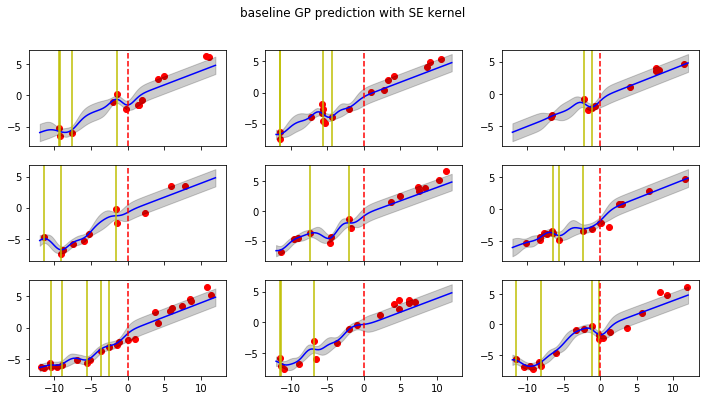

In [7]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

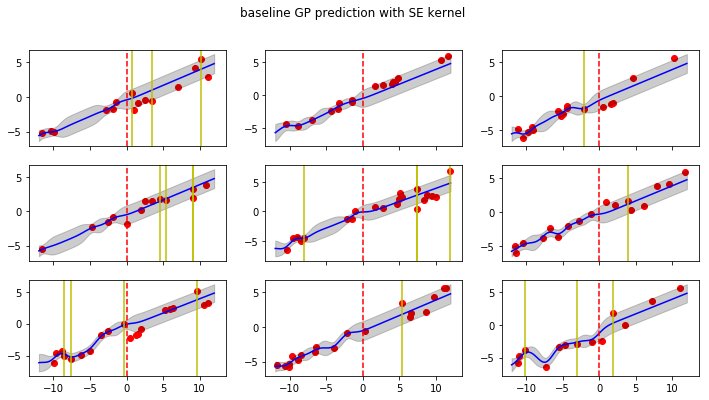

In [8]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [9]:
m = linear_mean(1)
tr = []
tr.append( (1.0, Treatment(4.0)) )
bgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 6698.830969406224
obj= 6073.3480851906525
obj= 5933.9555731585315
obj= 5924.166229555321
obj= 5574.238993076156
obj= 5208.140568469065
obj= 5200.83519522272
obj= 5200.648032434551
obj= 5200.64729403586
obj= 5200.647285853307
obj= 5200.647285768641
obj= 5200.647285766029
obj= 5200.647285766026
{'linear_mean_coef': array([ 0.49428861, -0.13626388]), 'ln_cov_l_F': array([0.]), 'effects_window_F': array([4.]), 'treatment': array([-1.26349935]), 'ln_cov_y': array([-1.42174855]), 'ln_cov_a_F': array([0.])}


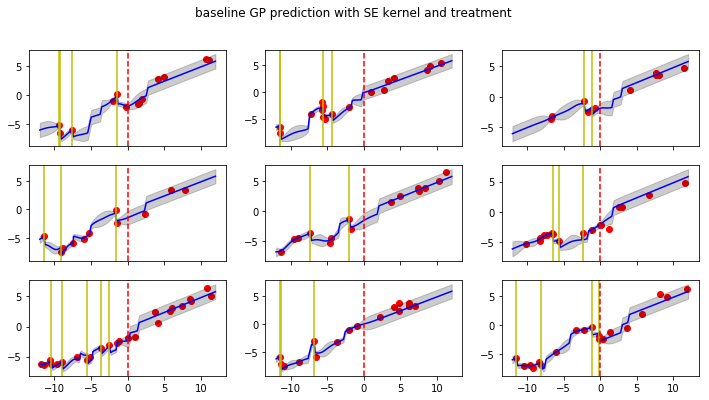

In [10]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

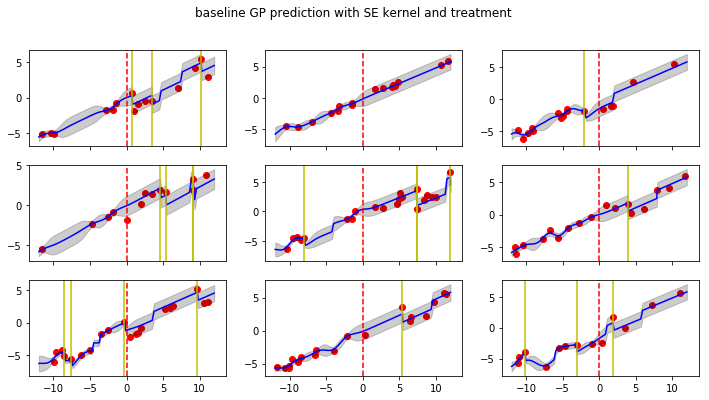

In [11]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [12]:
m = linear_mean(1)
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(4.0)) )
ac = BinaryActionModel()
cgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [9772.51905752]
obj= [8250.64109653]
obj= [8016.47596622]
obj= [7940.689177]
obj= [7939.45357427]
obj= [7763.91094053]
obj= [7635.74835998]
obj= [7630.92440959]
obj= [7630.83856414]
obj= [7630.83642582]
obj= [7630.83636356]
obj= [7630.83636316]
obj= [7630.83636316]
obj= [7630.83636316]
{'linear_mean_coef': array([ 0.48417059, -0.20116968]), 'ln_cov_l_F': array([0.]), 'effects_window_F': array([4.]), 'treatment': array([-1.39954937]), 'action': array([-1.29698753]), 'ln_cov_y': array([-1.47145749]), 'ln_cov_a_F': array([0.])}


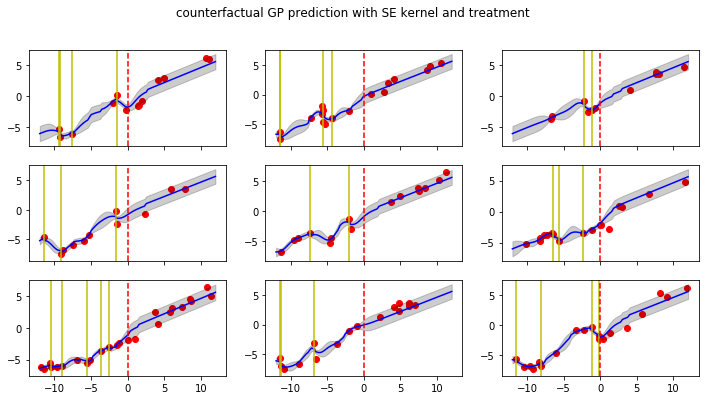

In [13]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

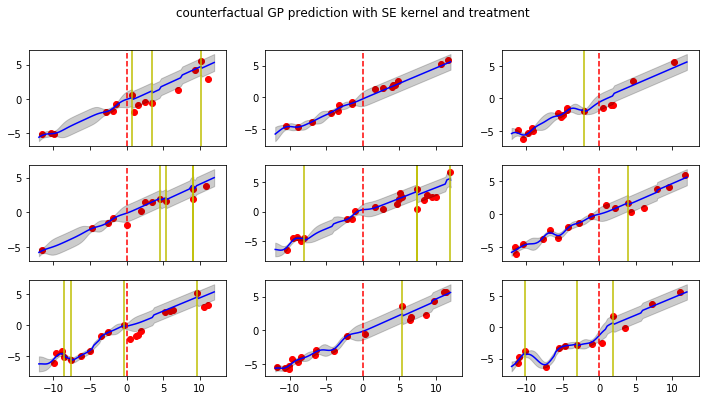

In [14]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)